In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('/content/gdrive/My Drive/uci-news-aggregator.csv',usecols=['TITLE','CATEGORY'])
print(data.head())

                                               TITLE CATEGORY
0  Fed official says weak data caused by weather,...        b
1  Fed's Charles Plosser sees high bar for change...        b
2  US open: Stocks fall after Fed official hints ...        b
3  Fed risks falling 'behind the curve', Charles ...        b
4  Fed's Plosser: Nasty Weather Has Curbed Job Gr...        b


In [4]:
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [5]:
num_of_categories = 45639
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
#shuffled new dataset
new_data = pd.concat([e,b,t,m], ignore_index=True)
new_data = new_data.reindex(np.random.permutation(new_data.index))
print(new_data)

                                                    TITLE CATEGORY
150806    Report: Married folks have fewer heart problems        m
146937  US storage room clear-out uncovers vials of sm...        m
47091   A Libyan Militia Tries—and Fails—to Sell Crude...        b
162406  Sperm, semen defects may be linked to shorter ...        m
46535   Report: Sprint and T-Mobile have agreed to mer...        b
...                                                   ...      ...
181534  Cochlear Implant Shocks Can Help Regrow Audito...        m
148704             Smell test may help detect Alzheimer's        m
132839  Ford Shows a New Mustang but Holds Back the De...        t
47019                Markets hit as investors dump stocks        b
68015   Asia stocks muted as China data, Wall St weigh...        b

[182556 rows x 2 columns]


In [6]:
#adding a new column to the new_data
new_data['LABEL']=0
new_data.head()
new_data.loc[new_data['CATEGORY'] == 'e', 'LABEL'] = 0
new_data.loc[new_data['CATEGORY'] == 'b', 'LABEL'] = 1
new_data.loc[new_data['CATEGORY'] == 't', 'LABEL'] = 2
new_data.loc[new_data['CATEGORY'] == 'm', 'LABEL'] = 3
print(new_data['LABEL'][:10])
from tensorflow.keras.utils import to_categorical
labels = to_categorical(new_data['LABEL'], num_classes=4)
print(labels[:10])

150806    3
146937    3
47091     1
162406    3
46535     1
77675     1
81498     1
105599    2
179923    3
150731    3
Name: LABEL, dtype: int64
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [7]:
l = list(new_data.TITLE.values)
m = len(max(l,key=len))
m

28426

In [8]:
most_common = 20000
max_len = 100
from tensorflow.keras.preprocessing.text import Tokenizer
tok = Tokenizer(num_words = most_common,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tok.fit_on_texts(new_data['TITLE'].values)
sequences = tok.texts_to_sequences(new_data['TITLE'].values)
word_index = tok.word_index
print('Found %s unique tokens.' % len(word_index))
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_data = pad_sequences(sequences, maxlen = max_len)
X_data

Found 52832 unique tokens.


array([[   0,    0,    0, ..., 1957,  154,  780],
       [   0,    0,    0, ..., 1824,    4, 1593],
       [   0,    0,    0, ...,    1,  431, 1478],
       ...,
       [   0,    0,    0, ...,   99,    3,  749],
       [   0,    0,    0, ...,  711, 6702,   74],
       [   0,    0,    0, ..., 9257,  261, 7063]], dtype=int32)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data , labels, test_size=0.25, random_state=42)
epochs = 2
embed_dim = 100
batch_size = 50
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((136917, 100), (136917, 4), (45639, 100), (45639, 4))


In [10]:
#building the nlp model
#loading the word vectors
#loading pretrained wordvectors
word2vec = {}
with open(os.path.join('/content/gdrive/My Drive/glove.6B.100d.txt'),encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word2vec[word] = coefs
num_of_words = min(most_common, len(word_index)+1)
embedding_matrix = np.zeros((num_of_words,embed_dim))
for word,i in word_index.items():
    if i < num_of_words:
        embedd_vec = word2vec.get(word)
        if embedd_vec is not None:
            embedding_matrix[i] = embedd_vec


In [11]:
def attentionLayer(hidden_vectors,cnn_vector):
  hidden_size = int(hidden_vectors.shape[2])
  preActivation = Dense(hidden_size, use_bias=False, activation= "tanh")(cnn_vector)
  h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_vectors)
  score = dot([cnn_vector,h_t], [2, 1])
  alphas = Activation('softmax')(score)
  contextVector = Dot(axes=[1, 1], name='context_vector')([cnn_vector, alphas])
  return contextVector

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, dot
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import Callback
import tensorflow
def createModel(num_of_words, max_len, embedMatrix, lstm_units, num_classes):
  #creating the embedding layer
  embedding_layer = Embedding(input_dim=num_of_words,output_dim=max_len,weights=[embedMatrix],input_length=max_len,trainable=False)
  #input_layer
  input_layer = Input((max_len,),name='InputLayer')
  #embedding layer
  embedding_layer = embedding_layer(input_layer)
  #bi-directional LSTM layer
  lstm = Bidirectional(LSTM(50,return_sequences=True))(embedding_layer)
  #dropout layer
  drop_lstm = Dropout(0.3)(lstm)
  #CNN layers
  first_conv_layer = Conv1D(100, 3, activation='relu')(lstm)
  first_conv_max_pooling = MaxPooling1D(3)(first_conv_layer)

  #attention mechanism
  attention = attentionLayer(lstm, first_conv_max_pooling ) 
  output_layer = Dense(4, use_bias=False, activation='softmax', name='attention_vector')(attention)
  model = Model(input_layer,output_layer)
  model.compile(
          loss='categorical_crossentropy',
          optimizer=Adam(learning_rate=0.01),
          metrics=['accuracy']
              )
  return model

model = createModel(num_of_words, max_len,  embedding_matrix, lstm_units=50, num_classes=4)

In [12]:
from tensorflow.keras.callbacks import Callback
import tensorflow

class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["accuracy"]
        if acc >= self.threshold:
            self.model.stop_training = True


callback=MyThresholdCallback(threshold=0.93)
r = model.fit(
           X_train, y_train,
            batch_size=50,
            epochs=200,
            validation_split=0.2,
            callbacks=[callback]  
            )

Epoch 1/200
2191/2191 [==============================] - 148s 52ms/step - loss: 0.3689 - accuracy: 0.8677 - val_loss: 0.3208 - val_accuracy: 0.8854
Epoch 2/200
2191/2191 [==============================] - 109s 50ms/step - loss: 0.2785 - accuracy: 0.9015 - val_loss: 0.2894 - val_accuracy: 0.8979
Epoch 3/200
2191/2191 [==============================] - 116s 53ms/step - loss: 0.2496 - accuracy: 0.9114 - val_loss: 0.2949 - val_accuracy: 0.8991
Epoch 4/200
2191/2191 [==============================] - 115s 52ms/step - loss: 0.2325 - accuracy: 0.9170 - val_loss: 0.2811 - val_accuracy: 0.9032
Epoch 5/200
2191/2191 [==============================] - 114s 52ms/step - loss: 0.2197 - accuracy: 0.9223 - val_loss: 0.2910 - val_accuracy: 0.8997
Epoch 6/200
2191/2191 [==============================] - 113s 52ms/step - loss: 0.2104 - accuracy: 0.9244 - val_loss: 0.2879 - val_accuracy: 0.9015
Epoch 7/200
2191/2191 [==============================] - 113s 52ms/step - loss: 0.2032 - accuracy: 0.9276 - val_

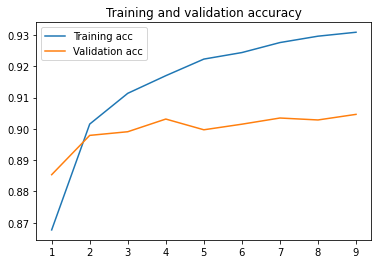

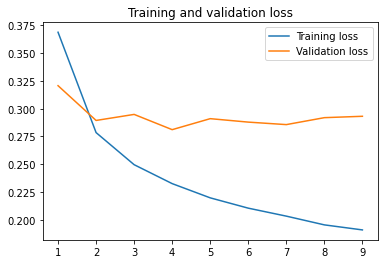

In [13]:
import matplotlib.pyplot as plt

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tok.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'technology', 'medical']
print(pred, labels[np.argmax(pred)])

[[2.4735189e-07 7.1534714e-06 2.2652893e-07 9.9999237e-01]] medical


In [19]:
model.save("bilstmCNNAtt.h5")

In [17]:
dataCopy = data